In [53]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_json("data/ironOrePriceJSON.txt")
df["year"] = df["date"].dt.year.astype("str")
df["month"] = df["date"].dt.month.astype("str")

for i in range(len(df["month"])):
    if len(str(df.iloc[i, 3])) == 1:
        df.iloc[i, 3] = "0" + str(df.iloc[i, 3])

df["ym"] = df["year"].map(str) + "-" + df["month"].map(str)
display(df)

,date,price,year,month,ym
0,2001-09-28,18.10,2001,09,2001-09
1,2001-10-31,18.10,2001,10,2001-10
2,2001-11-30,18.10,2001,11,2001-11
3,2001-12-31,18.10,2001,12,2001-12
4,2002-01-31,18.10,2002,01,2002-01
...,...,...,...,...,...
729,2021-07-30,197.12,2021,07,2021-07
730,2021-08-06,179.37,2021,08,2021-08
731,2021-08-13,163.24,2021,08,2021-08
732,2021-08-20,150.15,2021,08,2021-08


,price
ym,
2001-09-01,18.1000
2001-10-01,18.1000
2001-11-01,18.1000
2001-12-01,18.1000
2002-01-01,18.1000
...,...
2021-04-01,178.5280
2021-05-01,207.2250
2021-06-01,213.0300


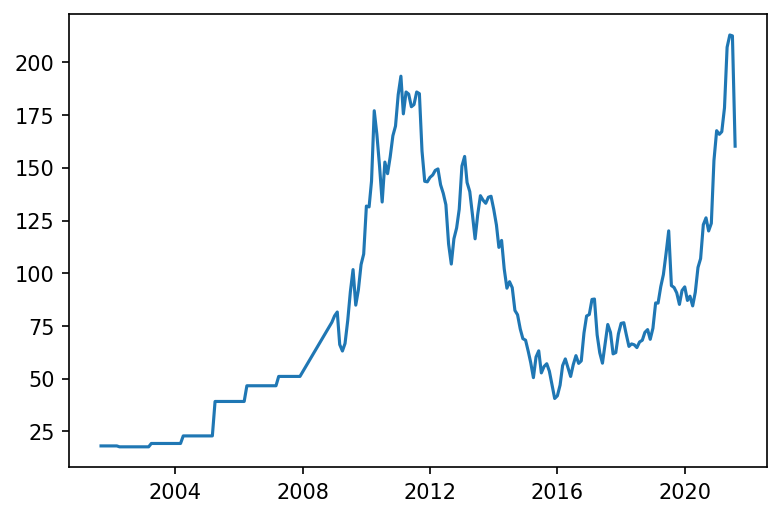

In [65]:
df_gr = df.groupby(by="ym")
mean_by_ym = df_gr.mean()
mean_by_ym.index = pd.to_datetime(mean_by_ym.index)
display(mean_by_ym)

plt.figure(dpi=150)
plt.plot(mean_by_ym.index, mean_by_ym["price"])
plt.show()

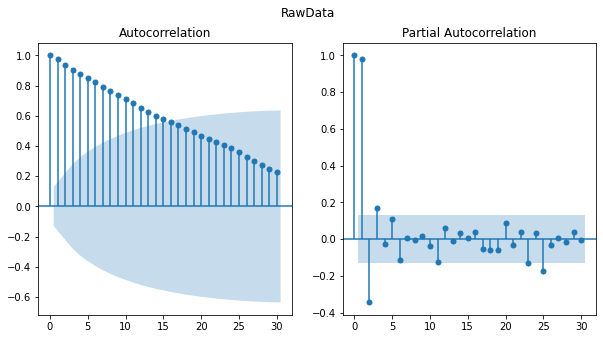

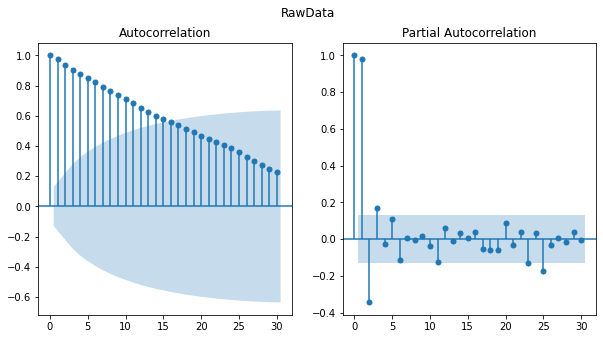

In [74]:
import statsmodels.api as sm

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("RawData")
sm.graphics.tsa.plot_acf(mean_by_ym.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(mean_by_ym.values.squeeze(), lags=30, ax=ax[1])

ym
2001-10-01     0.0000
2001-11-01     0.0000
2001-12-01     0.0000
2002-01-01     0.0000
2002-02-01     0.0000
               ...   
2021-04-01    11.3605
2021-05-01    28.6970
2021-06-01     5.8050
2021-07-01    -0.4060
2021-08-01   -52.3365
Name: price, Length: 228, dtype: float64


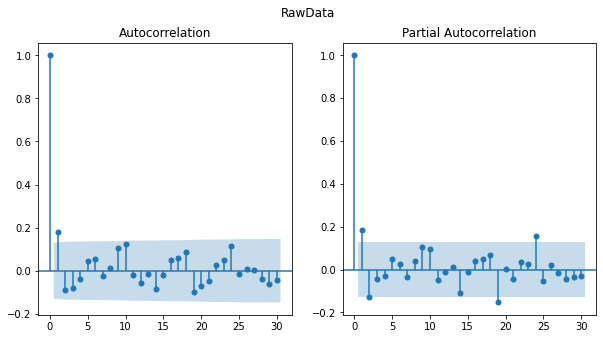

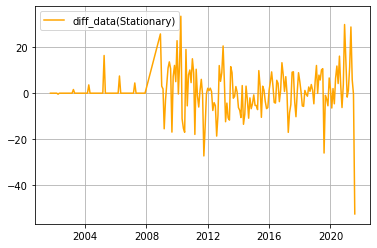

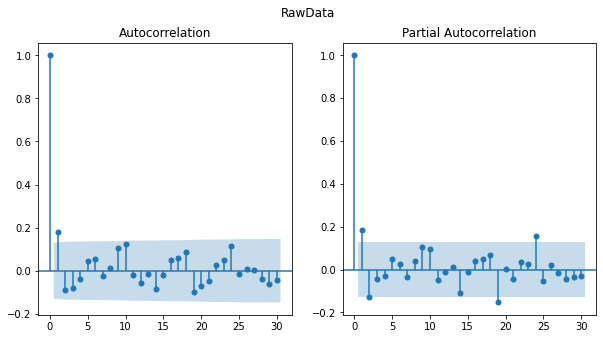

In [76]:
#차분한다.
diff_data = mean_by_ym.copy()
diff_data = diff_data["price"].diff()
diff_data.dropna(inplace=True)
print(diff_data)
plt.plot(diff_data, "orange", label="diff_data(Stationary)")
plt.grid()
plt.legend()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("RawData")
sm.graphics.tsa.plot_acf(diff_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_data.values.squeeze(), lags=30, ax=ax[1])

#정상성을 보이는 것으로 보임. 3~4개 튀는 것들이 있으나 무시해도 좋음

In [101]:
from sklearn.model_selection import train_test_split
import itertools
import warnings
warnings.filterwarnings("ignore")

train_data, test_data = train_test_split(mean_by_ym, test_size=0.05, shuffle=False)

#원래는 위 표에 따라 p,d,q를 결정해야 하지만 iterative 하게 할거임
p = range(0, 3)
d = range(1, 2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q)) #세가지 배열의 값을 각각 조합하여 새로운 배열로 만들어 줌

aic = []
for i in pdq:
    model = sm.tsa.ARIMA(train_data.values, order=(i))
    model_fit = model.fit()
    print("ARIMA Order : {} -> AIC : {}".format(i, model_fit.aic))
    aic_dict = { "order": i, "aic" : model_fit.aic }
    aic.append(aic_dict)

result_by_aic = pd.DataFrame(aic)
result_by_aic.sort_values(by="aic", ascending=True, inplace=True)
result_by_aic.reset_index(inplace=True)
result_by_aic

ARIMA Order : (0, 1, 0) -> AIC : 1503.2570914506066
ARIMA Order : (0, 1, 1) -> AIC : 1496.4889804003574
ARIMA Order : (0, 1, 2) -> AIC : 1496.1973219837114
ARIMA Order : (1, 1, 0) -> AIC : 1498.3710106695264
ARIMA Order : (1, 1, 1) -> AIC : 1496.0723020684436
ARIMA Order : (1, 1, 2) -> AIC : 1498.0169110829538
ARIMA Order : (2, 1, 0) -> AIC : 1497.401913312087
ARIMA Order : (2, 1, 1) -> AIC : 1498.0178213463246
ARIMA Order : (2, 1, 2) -> AIC : 1499.805513869916


,index,order,aic
0,4,"(1, 1, 1)",1496.072302
1,2,"(0, 1, 2)",1496.197322
2,1,"(0, 1, 1)",1496.488980
3,6,"(2, 1, 0)",1497.401913
4,5,"(1, 1, 2)",1498.016911
5,7,"(2, 1, 1)",1498.017821
6,3,"(1, 1, 0)",1498.371011
7,8,"(2, 1, 2)",1499.805514
8,0,"(0, 1, 0)",1503.257091


In [102]:
#aic가 가장 낮은 모델로 select 하여 summary를 본다
model_opt = sm.tsa.ARIMA(train_data.values, order=result_by_aic.iloc[0,1])
model_opt_fit = model_opt.fit()
model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  216
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -744.036
Method:                       css-mle   S.D. of innovations              7.580
Date:                Fri, 10 Sep 2021   AIC                           1496.072
Time:                        16:21:25   BIC                           1509.573
Sample:                             1   HQIC                          1501.527
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4965      0.596      0.833      0.405      -0.672       1.665
ar.L1.D.y     -0.3742      0.184     -2.029      0.042      -0.736      -0.013
ma.L1.D.y      0.5896      0.157      3.762      0.000       0.282       0.897
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.6724           +0.0000j            2.6724            0.5000
MA.1           -1.6961           +0.0000j            1.6961            0.5000
-----------------------------------------------------------------------------
"""

Text(0.5, 0.98, 'ARIMA (1, 1, 1) Prediction Results (r2_score : -1.35)')

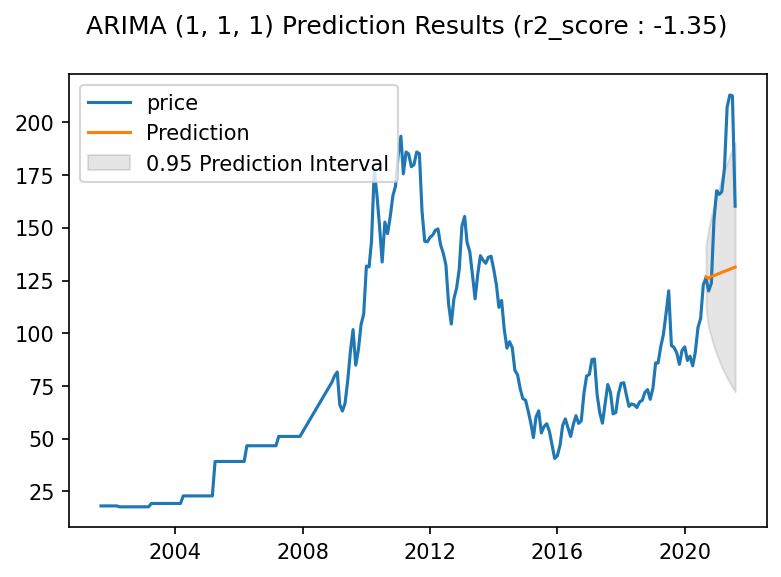

In [103]:
import datetime
import numpy as np
from sklearn.metrics import r2_score

prediction = model_opt_fit.forecast(len(test_data))
predicted_value = prediction[0]
predicted_ub = prediction[2][:,0]
predicted_lb = prediction[2][:,1]
predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)

# forecast_start_date = datetime.datetime(1958, 8, 1)
# forecast_start_date = np.datetime64(forecast_start_date)
plt.figure(dpi=150)
plt.plot(mean_by_ym.index, mean_by_ym["price"], label="price")
# plt.vlines(forecast_start_date, 0, 1000, linestyle="--", color="r", label="Forecast Start")
plt.plot(predict_index, predicted_value, label = "Prediction")
plt.fill_between(predict_index, predicted_lb, predicted_ub, color="k", alpha=0.1, label="0.95 Prediction Interval")
plt.legend(loc="upper left")
plt.suptitle("ARIMA {} Prediction Results (r2_score : {:4.2f})".format(result_by_aic.iloc[0,1], r2))

In [125]:
#SARIMA - auto_arima로 한방에 모델 셀렉션이 가능
from pmdarima import auto_arima
aa_model = auto_arima(train_data,
                      start_p=0,
                      d=1,
                      start_q=0,
                      max_p=3,
                      max_d=3,
                      max_q=3,
                      start_P=0,
                      D=1,
                      start_Q=0,
                      max_P=3,
                      max_D=3,
                      max_Q=3,
                      m=4,
                      seasonal=True,
                      trace=True,
                      error_action="ignore",
                      suppress_warnings=True,
                      stepwise=False)
aa_model.summary()

 ARIMA(0,1,0)(0,1,0)[4]             : AIC=1641.027, Time=0.02 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,1,2)[4]             : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,1,3)[4]             : AIC=inf, Time=0.26 sec
 ARIMA(0,1,0)(1,1,0)[4]             : AIC=1550.781, Time=0.02 sec
 ARIMA(0,1,0)(1,1,1)[4]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(1,1,2)[4]             : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(1,1,3)[4]             : AIC=inf, Time=0.34 sec
 ARIMA(0,1,0)(2,1,0)[4]             : AIC=1535.662, Time=0.04 sec
 ARIMA(0,1,0)(2,1,1)[4]             : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(2,1,2)[4]             : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(2,1,3)[4]             : AIC=inf, Time=0.58 sec
 ARIMA(0,1,0)(3,1,0)[4]             : AIC=1517.511, Time=0.05 sec
 ARIMA(0,1,0)(3,1,1)[4]             : AIC=inf, Time=0.37 sec
 ARIMA(0,1,0)(3,1,2)[4]             : AIC=inf, Time=0.46 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=1635.016, Time=0.02 sec

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  217
Model:             SARIMAX(1, 1, 1)x(3, 1, [], 4)   Log Likelihood                -747.627
Date:                            Fri, 10 Sep 2021   AIC                           1507.255
Time:                                    16:40:03   BIC                           1527.395
Sample:                                         0   HQIC                          1515.395
                                            - 217                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6418      0.088     -7.290      0.000      -0.814      -0.469
ma.L1          0.8532      0.060     14.253      0.000       0.736       0.971
ar.S.L4       -0.8049      0.062    -13.003      0.000      -0.926      -0.684
ar.S.L8       -0.4620      0.072     -6.437      0.000      -0.603      -0.321
ar.S.L12      -0.2843      0.057     -5.015      0.000      -0.395      -0.173
sigma2        66.4043      4.864     13.652      0.000      56.871      75.938
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                27.91
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):              10.55   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [122]:
#aic가 가장 낮은 모델로 select 하여 summary를 본다
model_opt = sm.tsa.SARIMAX(train_data.values, order=aa_model.get_params()["order"], seasonal_order=aa_model.get_params()["seasonal_order"])
model_opt_fit = model_opt.fit()
model_opt_fit.summary()

prediction = model_opt_fit.get_forecast(len(test_data))
predicted_value = prediction.predicted_mean
predicted_ub = prediction.conf_int()[:,0]
predicted_lb = prediction.conf_int()[:,1]
predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)

plt.figure(dpi=150)
plt.plot(mean_by_ym.index, mean_by_ym["price"], label="price")
# plt.vlines(forecast_start_date, 0, 1000, linestyle="--", color="r", label="Forecast Start")
plt.plot(predict_index, predicted_value, label = "Prediction")
plt.fill_between(predict_index, predicted_lb, predicted_ub, color="k", alpha=0.1, label="0.95 Prediction Interval")
plt.legend(loc="upper left")
plt.suptitle("SARIMA {} {}, Prediction Results (r2_score : {:4.2f})".format(aa_model.get_params()["order"], aa_model.get_params()["seasonal_order"], r2))

array([129.42342629, 129.96512598, 134.7887459 , 129.32684432,
       133.35424858, 135.2964946 , 136.69549307, 142.05929112,
       146.76477523, 147.53360169, 150.81284443, 151.5101948 ,
       156.8013285 , 161.05109521, 164.22598609, 169.79418126,
       174.97520568, 176.56551573, 179.93046698, 180.65551446,
       185.46225381, 187.91831075, 190.64410249, 194.34365465,
       199.33608298, 201.33422339, 204.51635378, 206.67438563,
       211.72158687, 214.44443692, 217.50051891, 220.90207345,
       225.92581975, 228.03077498, 231.15921128, 233.42635428])